In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
from matplotlib.ticker import ScalarFormatter
import math
from scipy.stats.mstats import gmean
from scipy.stats import gamma, poisson, linregress, beta, norm
from scipy import optimize
from scipy import interpolate
import time
import random
import pickle as pkl
from craterdata import *
from itertools import product
from matplotlib.patches import Arrow
%matplotlib inline

In [2]:
pf_slope = -2.0
pf = loglog_linear_pf(N1=0.001, slope=pf_slope)
N_array = np.round([10.0**(i) for i in np.arange(1, 4, 0.1)]).astype('int')
synth_area = 10000

params_list = [
    SlopeSearchParams(
        plot_type=plot_type,
        use_uncertainties=use_uncertainties,
        pick_a_side=pick_a_side
    )
    for plot_type in ['unbinned', 'unbinned corrected', 'left']
    for use_uncertainties in [False, True]
    for pick_a_side in [False, True] if 
    use_uncertainties or not pick_a_side
]

key_list = [params.str for params in params_list] + ['mle']

if True:
    slope_list_list_dict = {}
    for params in params_list:
        with open('saved/slope.' + params.file_str + '.pkl', 'rb') as f:
            slope_list_list_dict[params.str] = pkl.load(f)
    with open('saved/slope.mle.pkl', 'rb') as f:
        slope_list_list_dict['mle'] = -1 * pkl.load(f)

In [3]:
t1 = time.time()
if False:
    mean_dict = {
        key : [
            np.mean(slopes) 
            for slopes in slope_list_list_dict[key]
        ]
        for key in slope_list_list_dict.keys()
    }
    std_dict = {
        key : [
            np.std(slopes) 
            for slopes in slope_list_list_dict[key]
        ]
        for key in slope_list_list_dict.keys()
    }
    median_dict = {
        key : [
            np.median(slopes) 
            for slopes in slope_list_list_dict[key]
        ]
        for key in slope_list_list_dict.keys()
    }
    with open('saved/slope.mean_dict.pkl', 'wb') as f:
        pkl.dump(mean_dict, f)
    with open('saved/slope.std_dict.pkl', 'wb') as f:
        pkl.dump(std_dict, f)
    with open('saved/slope.median_dict.pkl', 'wb') as f:
        pkl.dump(median_dict, f)
else:
    with open('saved/slope.mean_dict.pkl', 'rb') as f:
        mean_dict = pkl.load(f)
    with open('saved/slope.std_dict.pkl', 'rb') as f:
        std_dict = pkl.load(f)
    with open('saved/slope.median_dict.pkl', 'rb') as f:
        median_dict = pkl.load(f)
t2 = time.time()
print(format_runtime(t2 - t1))

0.00143 seconds


In [4]:
t1 = time.time()
if False:
    mean_matrix_dict = {
        key : np.array([
            mean_slope_fit(slopes)
            for slopes in slope_list_list_dict[key]
        ])
        for key in slope_list_list_dict.keys()
    }
    with open('saved/mean_matrix_dict.pkl', 'wb') as f:
        pkl.dump(mean_matrix_dict, f)
else:
    with open('saved/mean_matrix_dict.pkl', 'rb') as f:
        mean_matrix_dict = pkl.load(f)
t2 = time.time()
print(format_runtime(t2 - t1))

0.00048 seconds


In [5]:

c_dict = {key_list[i] : cs[i] for i in range(len(key_list))}

def plot_type_label(key):
    plot_type = key.split('_u')[0]
    plot_type_label_dict = {
        'unbinned' : 'Traditional Cumulative Plot',
        'unbinned_cor' : 'Corrected Cumulative Plot',
        'left' : '\"Binned\" Cumulative Plot'
    }
    return plot_type_label_dict[plot_type]

uncertainty_label_dict = {
    0 : 'No Uncertainties',
    1 : 'Symmetric Uncertainties',
    2 : 'Asymmetric Uncertainties'
}

label_dict = {
    'unbinned' : 'No Uncertainties',
    'unbinned_u' : 'Symmetric Uncertainties',
    'unbinned_u_p' : 'Asymmetric Uncertainties',
    'unbinned_cor' : 'No Uncertainties, Corrected',
    'unbinned_cor_u' : 'Symmetric Uncertainties, Corrected',
    'unbinned_cor_u_p' : 'Asymmetric Uncertainties, Corrected',
}

In [6]:
example_N_i = 10
example_N = N_array[example_N_i]
example_N2_i = 20
example_N2 = N_array[example_N2_i]

def plot_mean_matrix(matrix, Ns, color='black', ms=7, lw=1, elw=1):
    mean, lower, upper = tuple(matrix.T)
    plt.errorbar(
        Ns, mean, [lower, upper], fmt='.', color=color,
        elinewidth=elw, ms=ms
    )
    plt.plot(Ns, mean, color=color, lw=lw)

def plot_type_label(key):
    plot_type = key.split('_u')[0]
    plot_type_label_dict = {
        'unbinned' : 'Traditional Cumulative Plot',
        'unbinned_cor' : 'Corrected Cumulative Plot',
        'left' : '\"Binned\" Cumulative Plot'
    }
    return plot_type_label_dict[plot_type]

uncertainty_label_dict = {
    0 : 'No Uncertainties',
    1 : 'Symmetric Uncertainties',
    2 : 'Asymmetric Uncertainties'
}

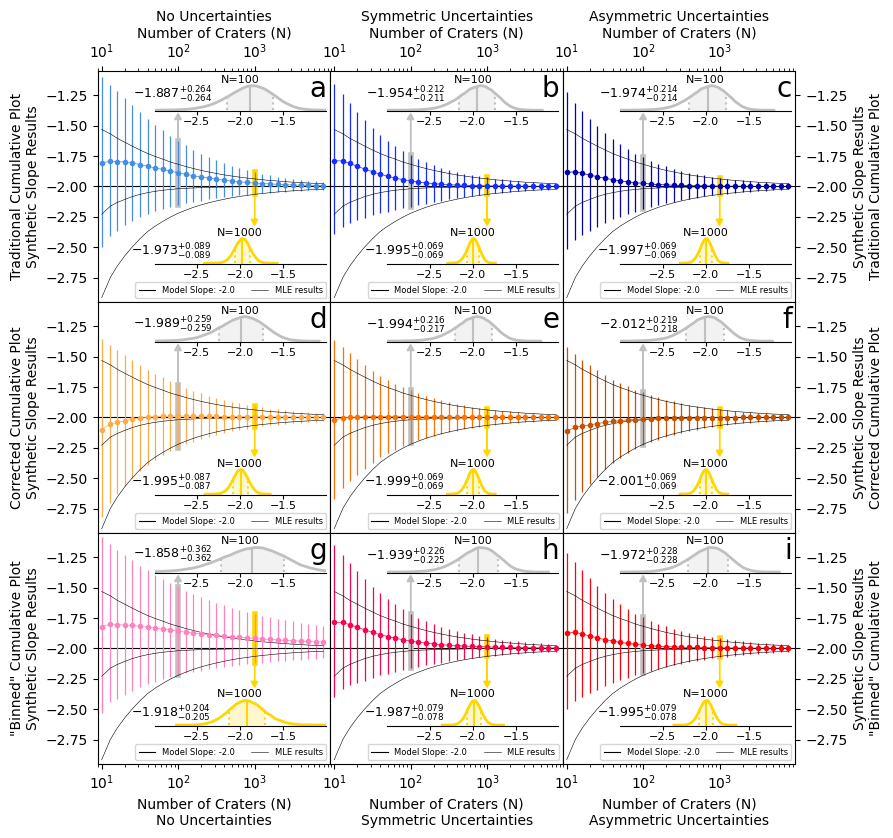

In [7]:
fig = plt.figure(figsize=(9, 9))

xlim = [10**0.95, 10**3.99]
ylim = [-2.95, -1.05]
X = np.logspace(1, 4, 200, endpoint=True)
search_m = -2.0
h, w = 3, 3


for i in range(h * w):
    ax = plt.subplot(h, w, i + 1)
    plt.plot(
        xlim, [search_m, search_m], 'k', lw=0.8, label='Model Slope: -2.0'
    )
    mean, lower, upper = tuple(mean_matrix_dict[key_list[i]][example_N_i])
    high, low = mean + upper, mean - lower
    plt.plot([example_N, example_N], [low, high], color='silver', lw=4)
    mean, lower, upper = tuple(mean_matrix_dict[key_list[i]][example_N2_i])
    high2, low2 = mean + upper, mean - lower
    plt.plot([example_N2, example_N2], [low2, high2], color='gold', lw=4)
    plot_mean_matrix(
        mean_matrix_dict[key_list[i]], N_array, color=cs[i],
        ms=6, elw=0.9, lw=0.5
    )
    plt.xscale('log')
    plt.xlim(xlim)
    plt.ylim(ylim)
    if (i + 1) % w == 0:
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position('right')
        plt.ylabel('Synthetic Slope Results\n' + plot_type_label(key_list[i]))
    elif i % w > 0:
        plt.yticks([])
        plt.ylabel('')
    else:
        plt.ylabel(plot_type_label(key_list[i]) + '\nSynthetic Slope Results')
    if i < w:
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top')
        plt.xlabel(uncertainty_label_dict[i % w] + '\nNumber of Craters (N)')
    if i >= w * (h - 1):
        plt.xlabel('Number of Craters (N)\n' + uncertainty_label_dict[i % w])
    if i >= w and i < w * (h - 1):
        plt.xticks([])
    # plt.text(0.985, 0.985, chr(ord('a') + i), transform=plt.gca().transAxes, 
    #          ha='right', va='top', size=20)
    plt.arrow(100, low, 0, -1.40 - low, color='silver',
              length_includes_head=True, head_width=20,
              head_length=0.05)
    plt.arrow(1000, low2, 0, -2.32 - low2, color='gold',
              length_includes_head=True, head_width=200,
              head_length=0.05)
    line1 = Line2D([], [], color='black', lw=0.75, 
                   label='(a) Max Likelihood')
    line2 = Line2D([], [], color='black', lw=0.75, linestyle=':', 
                   label='(a) Error Bounds')

    mean, lower, upper = tuple(mean_matrix_dict['mle'].T)
    plt.plot(
        N_array, mean, 'k', lw=0.4,
        label='MLE results'
    )
    plt.plot(N_array, mean - lower, color='k', lw=0.4)
    plt.plot(N_array, mean + upper, color='k', lw=0.4)

    plt.text(
        0.985, 0.985, chr(ord('a') + i), 
        transform=plt.gca().transAxes, 
        ha='right', va='top', size=20
    )

    plt.legend(fontsize=6, loc=4, ncol=2)
    
fig.subplots_adjust(hspace=0, wspace=0)

for i, j in product(range(w), range(h)):
    ax_inset = fig.add_axes([0.188 + 0.2587 * i, 0.835 - 0.2566 * j, 
                             0.19, 0.03])
    erase_box(ax_inset)
    key = key_list[i + w * j]
    example_N_slopes = slope_list_list_dict[key][example_N_i]
    example_N_pdf = ash_pdf(example_N_slopes, nbins=50)
    example_N_pdf.plot(
        xlim=[-2.99, -1.01], color='silver', alpha=0.2, label=True,
        label_text_size=9, label_color='black', rounding_n=3,
        label_shift_x=-0.25, label_shift_y=0.15
    )
    ax_inset.set_title('N=100', size=8, pad=0)
    ax_inset.tick_params(size=3, labelsize=8, pad=1)
    ax_inset.set_facecolor((0, 0, 0, 0))
    ax_inset = fig.add_axes([0.188 + 0.2587 * i, 0.665 - 0.2566 * j, 
                             0.19, 0.03])
    erase_box(ax_inset)
    example_N2_slopes = slope_list_list_dict[key][example_N2_i]
    example_N2_pdf = ash_pdf(example_N2_slopes, nbins=50)
    example_N2_pdf.plot(
        xlim=[-2.99, -1.01], color='gold', alpha=0.2, label=True,
        label_text_size=9, label_color='black',
        rounding_n=3, label_shift_x=-0.27, label_shift_y=0.01
    )
    ax_inset.set_title('N=1000', size=8, pad=0)
    # ax_inset.set_xticks([-2.3, -2.0, -1.7])
    ax_inset.tick_params(size=3, labelsize=8, pad=1)
    ax_inset.set_facecolor((0, 0, 0, 0))

pfig = plt.gcf()
pfig.savefig('figs/N_search.pdf', bbox_inches='tight')

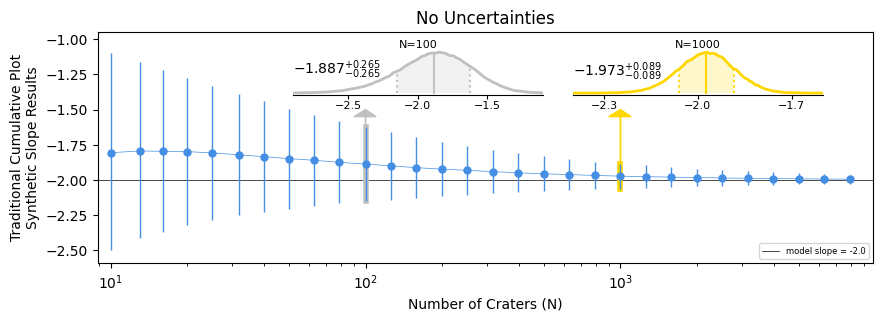

In [8]:
fig = plt.figure(figsize=(10, 3))

xlim = [10**0.95, 10**3.99]
ylim = [-2.59, -0.95]
X = np.logspace(1, 4, 200, endpoint=True)
search_m = -2.0
h, w = 3, 3

i = 0

plt.plot(
    xlim, [search_m, search_m], 'k', lw=0.5, label='model slope = -2.0'
)
mean, lower, upper = tuple(mean_matrix_dict[key_list[i]][example_N_i])
high, low = mean + upper, mean - lower
plt.plot([example_N, example_N], [low, high], color='silver', lw=4)
mean, lower, upper = tuple(mean_matrix_dict[key_list[i]][example_N2_i])
high2, low2 = mean + upper, mean - lower
plt.plot([example_N2, example_N2], [low2, high2], color='gold', lw=4)
plot_mean_matrix(
    mean_matrix_dict[key_list[i]], N_array, color=cs[i],
    ms=10, elw=1, lw=0.5
)
plt.xscale('log')
plt.xlim(xlim)
plt.ylim(ylim)
if (i + 1) % w == 0:
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')
    plt.ylabel('Synthetic Slope Results\n' + plot_type_label(key_list[i]))
elif i % w > 0:
    plt.yticks([])
    plt.ylabel('')
else:
    plt.ylabel(plot_type_label(key_list[i]) + '\nSynthetic Slope Results')
plt.xlabel('Number of Craters (N)')
plt.title(uncertainty_label_dict[i % w])
# plt.text(0.985, 0.985, chr(ord('a') + i), transform=plt.gca().transAxes, 
#          ha='right', va='top', size=20)
plt.arrow(100, high, 0, -1.50 - high, color='silver',
          length_includes_head=True, head_width=20,
          head_length=0.05)
plt.arrow(1000, high2, 0, -1.50 - high2, color='gold',
          length_includes_head=True, head_width=200,
          head_length=0.05)
line1 = Line2D([], [], color='black', lw=0.75, 
               label='(a) Max Likelihood')
line2 = Line2D([], [], color='black', lw=0.75, linestyle=':', 
               label='(a) Error Bounds')

plt.legend(fontsize=6, loc=4)

# plt.text(10.1, -1.98, 'model slope = -2.0')
    
fig.subplots_adjust(hspace=0, wspace=0)

ax_inset = fig.add_axes([0.32, 0.67, 0.25, 0.15])
erase_box(ax_inset)
key = key_list[0]
example_N_slopes = slope_list_list_dict[key][example_N_i]
example_N_pdf = make_pdf_from_samples(example_N_slopes, slope_data=True)
example_N_pdf.as_kind('mean').plot(
    xlim=[-2.9, -1.1], color='silver', alpha=0.2, label=True,
    label_color='black', rounding_n=3, label_shift_y=0.2
)
ax_inset.set_title('N=100', size=8, pad=0)
ax_inset.tick_params(size=3, labelsize=8, pad=1)
ax_inset.set_facecolor((0, 0, 0, 0))
ax_inset = fig.add_axes([0.6, 0.67, 0.25, 0.15])
erase_box(ax_inset)
example_N2_slopes = slope_list_list_dict[key][example_N2_i]
example_N2_pdf = make_pdf_from_samples(example_N2_slopes, slope_data=True)
example_N2_pdf.as_kind('mean').plot(
    xlim=[-2.4, -1.6], color='gold', alpha=0.2, label=True,
    label_color='black', rounding_n=3, label_shift_y=0.2
)
ax_inset.set_title('N=1000', size=8, pad=0)
ax_inset.set_xticks([-2.3, -2.0, -1.7])
ax_inset.tick_params(size=3, labelsize=8, pad=1)
ax_inset.set_facecolor((0, 0, 0, 0))

pfig = plt.gcf()
pfig.savefig('figs/N_search_no_errors.pdf', bbox_inches='tight')

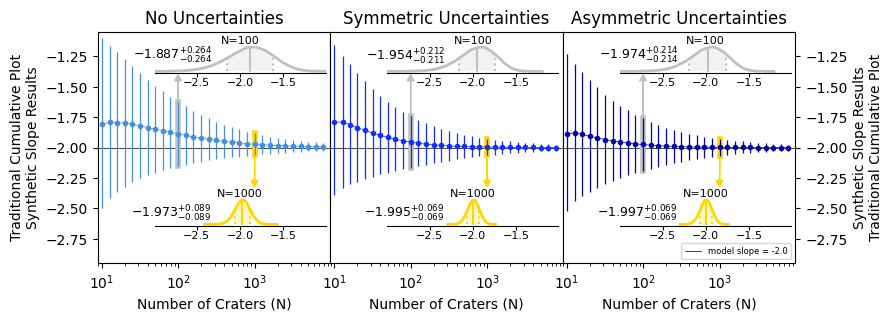

In [9]:
fig = plt.figure(figsize=(9, 9))

xlim = [10**0.95, 10**3.99]
ylim = [-2.95, -1.05]
X = np.logspace(1, 4, 200, endpoint=True)
search_m = -2.0
h, w = 3, 3


for i in range(3):
    ax = plt.subplot(h, w, i + 1)
    plt.plot(
        xlim, [search_m, search_m], 'k', lw=0.5, label='model slope = -2.0'
    )
    mean, lower, upper = tuple(mean_matrix_dict[key_list[i]][example_N_i])
    high, low = mean + upper, mean - lower
    plt.plot([example_N, example_N], [low, high], color='silver', lw=4)
    mean, lower, upper = tuple(mean_matrix_dict[key_list[i]][example_N2_i])
    high2, low2 = mean + upper, mean - lower
    plt.plot([example_N2, example_N2], [low2, high2], color='gold', lw=4)
    plot_mean_matrix(
        mean_matrix_dict[key_list[i]], N_array, color=cs[i],
        ms=6, elw=0.9, lw=0.5
    )
    plt.xscale('log')
    plt.xlim(xlim)
    plt.ylim(ylim)
    if (i + 1) % w == 0:
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position('right')
        plt.ylabel('Synthetic Slope Results\n' + plot_type_label(key_list[i]))
    elif i % w > 0:
        plt.yticks([])
        plt.ylabel('')
    else:
        plt.ylabel(plot_type_label(key_list[i]) + '\nSynthetic Slope Results')
    plt.xlabel('Number of Craters (N)')
    plt.title(uncertainty_label_dict[i % w])
    # plt.text(0.985, 0.985, chr(ord('a') + i), transform=plt.gca().transAxes, 
    #          ha='right', va='top', size=20)
    plt.arrow(100, low, 0, -1.40 - low, color='silver',
              length_includes_head=True, head_width=20,
              head_length=0.05)
    plt.arrow(1000, low2, 0, -2.32 - low2, color='gold',
              length_includes_head=True, head_width=200,
              head_length=0.05)
    line1 = Line2D([], [], color='black', lw=0.75, 
                   label='(a) Max Likelihood')
    line2 = Line2D([], [], color='black', lw=0.75, linestyle=':', 
                   label='(a) Error Bounds')

plt.legend(fontsize=6, loc=4)
    
fig.subplots_adjust(hspace=0, wspace=0)

for i, j in product(range(w), range(1)):
    ax_inset = fig.add_axes([0.188 + 0.2587 * i, 0.835 - 0.2566 * j, 
                             0.19, 0.03])
    erase_box(ax_inset)
    key = key_list[i + w * j]
    example_N_slopes = slope_list_list_dict[key][example_N_i]
    example_N_pdf = ash_pdf(example_N_slopes, nbins=50)
    example_N_pdf.plot(
        xlim=[-2.99, -1.01], color='silver', alpha=0.2, label=True,
        label_text_size=9, label_color='black', rounding_n=3,
        label_shift_x=-0.25, label_shift_y=0.15
    )
    ax_inset.set_title('N=100', size=8, pad=0)
    ax_inset.tick_params(size=3, labelsize=8, pad=1)
    ax_inset.set_facecolor((0, 0, 0, 0))
    ax_inset = fig.add_axes([0.188 + 0.2587 * i, 0.665 - 0.2566 * j, 
                             0.19, 0.03])
    erase_box(ax_inset)
    example_N2_slopes = slope_list_list_dict[key][example_N2_i]
    example_N2_pdf = ash_pdf(example_N2_slopes, nbins=50)
    example_N2_pdf.plot(
        xlim=[-2.99, -1.01], color='gold', alpha=0.2, label=True,
        label_text_size=9, label_color='black',
        rounding_n=3, label_shift_x=-0.27, label_shift_y=0.01
    )
    ax_inset.set_title('N=1000', size=8, pad=0)
    # ax_inset.set_xticks([-2.3, -2.0, -1.7])
    ax_inset.tick_params(size=3, labelsize=8, pad=1)
    ax_inset.set_facecolor((0, 0, 0, 0))

pfig = plt.gcf()
pfig.savefig('figs/N_search_traditional.pdf', bbox_inches='tight')

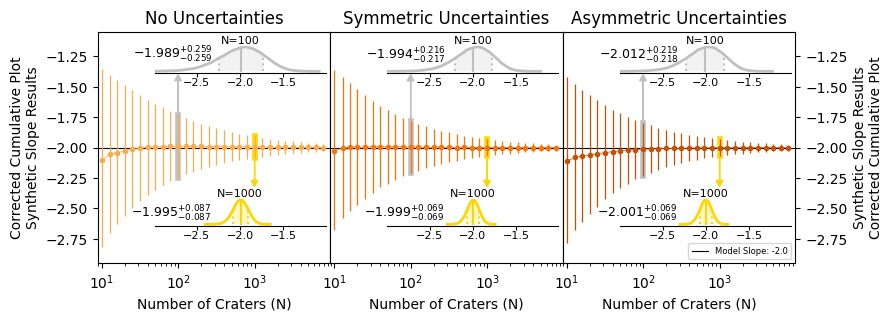

In [10]:
fig = plt.figure(figsize=(9, 9))

xlim = [10**0.95, 10**3.99]
ylim = [-2.95, -1.05]
X = np.logspace(1, 4, 200, endpoint=True)
search_m = -2.0
h, w = 3, 3


for i in range(3, 6):
    ax = plt.subplot(h, w, i + 1)
    plt.plot(
        xlim, [search_m, search_m], 'k', lw=0.8, label='Model Slope: -2.0'
    )
    mean, lower, upper = tuple(mean_matrix_dict[key_list[i]][example_N_i])
    high, low = mean + upper, mean - lower
    plt.plot([example_N, example_N], [low, high], color='silver', lw=4)
    mean, lower, upper = tuple(mean_matrix_dict[key_list[i]][example_N2_i])
    high2, low2 = mean + upper, mean - lower
    plt.plot([example_N2, example_N2], [low2, high2], color='gold', lw=4)
    plot_mean_matrix(
        mean_matrix_dict[key_list[i]], N_array, color=cs[i],
        ms=6, elw=0.9, lw=0.5
    )
    plt.xscale('log')
    plt.xlim(xlim)
    plt.ylim(ylim)
    if (i + 1) % w == 0:
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position('right')
        plt.ylabel('Synthetic Slope Results\n' + plot_type_label(key_list[i]))
    elif i % w > 0:
        plt.yticks([])
        plt.ylabel('')
    else:
        plt.ylabel(plot_type_label(key_list[i]) + '\nSynthetic Slope Results')
    plt.xlabel('Number of Craters (N)')
    plt.title(uncertainty_label_dict[i % w])
    # plt.text(0.985, 0.985, chr(ord('a') + i), transform=plt.gca().transAxes, 
    #          ha='right', va='top', size=20)
    plt.arrow(100, low, 0, -1.40 - low, color='silver',
              length_includes_head=True, head_width=20,
              head_length=0.05)
    plt.arrow(1000, low2, 0, -2.32 - low2, color='gold',
              length_includes_head=True, head_width=200,
              head_length=0.05)
    line1 = Line2D([], [], color='black', lw=0.75, 
                   label='(a) Max Likelihood')
    line2 = Line2D([], [], color='black', lw=0.75, linestyle=':', 
                   label='(a) Error Bounds')

plt.legend(fontsize=6, loc=4)
    
fig.subplots_adjust(hspace=0, wspace=0)

for i, j in product(range(w), range(1, 2)):
    ax_inset = fig.add_axes([0.188 + 0.2587 * i, 0.835 - 0.2566 * j, 
                             0.19, 0.03])
    erase_box(ax_inset)
    key = key_list[i + w * j]
    example_N_slopes = slope_list_list_dict[key][example_N_i]
    example_N_pdf = ash_pdf(example_N_slopes, nbins=50)
    example_N_pdf.plot(
        xlim=[-2.99, -1.01], color='silver', alpha=0.2, label=True,
        label_text_size=9, label_color='black', rounding_n=3,
        label_shift_x=-0.25, label_shift_y=0.15
    )
    ax_inset.set_title('N=100', size=8, pad=0)
    ax_inset.tick_params(size=3, labelsize=8, pad=1)
    ax_inset.set_facecolor((0, 0, 0, 0))
    ax_inset = fig.add_axes([0.188 + 0.2587 * i, 0.665 - 0.2566 * j, 
                             0.19, 0.03])
    erase_box(ax_inset)
    example_N2_slopes = slope_list_list_dict[key][example_N2_i]
    example_N2_pdf = ash_pdf(example_N2_slopes, nbins=50)
    example_N2_pdf.plot(
        xlim=[-2.99, -1.01], color='gold', alpha=0.2, label=True,
        label_text_size=9, label_color='black',
        rounding_n=3, label_shift_x=-0.27, label_shift_y=0.01
    )
    ax_inset.set_title('N=1000', size=8, pad=0)
    # ax_inset.set_xticks([-2.3, -2.0, -1.7])
    ax_inset.tick_params(size=3, labelsize=8, pad=1)
    ax_inset.set_facecolor((0, 0, 0, 0))

pfig = plt.gcf()
pfig.savefig('figs/N_search_row2.pdf', bbox_inches='tight')

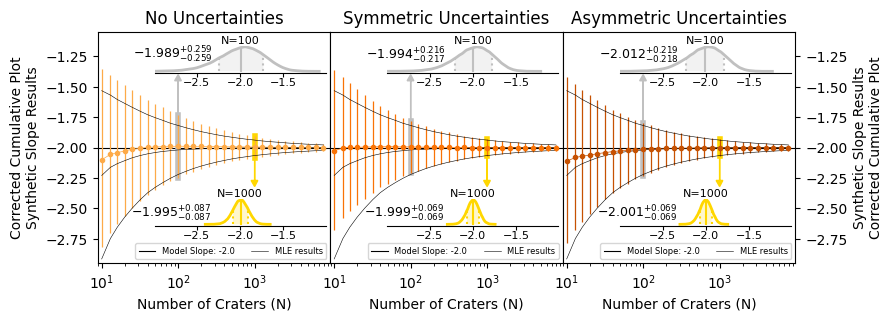

In [11]:
fig = plt.figure(figsize=(9, 9))

xlim = [10**0.95, 10**3.99]
ylim = [-2.95, -1.05]
X = np.logspace(1, 4, 200, endpoint=True)
search_m = -2.0
h, w = 3, 3


for i in range(3, 6):
    ax = plt.subplot(h, w, i + 1)
    plt.plot(
        xlim, [search_m, search_m], 'k', lw=0.8, label='Model Slope: -2.0'
    )
    mean, lower, upper = tuple(mean_matrix_dict[key_list[i]][example_N_i])
    high, low = mean + upper, mean - lower
    plt.plot([example_N, example_N], [low, high], color='silver', lw=4)
    mean, lower, upper = tuple(mean_matrix_dict[key_list[i]][example_N2_i])
    high2, low2 = mean + upper, mean - lower
    plt.plot([example_N2, example_N2], [low2, high2], color='gold', lw=4)
    plot_mean_matrix(
        mean_matrix_dict[key_list[i]], N_array, color=cs[i],
        ms=6, elw=0.9, lw=0.5
    )
    plt.xscale('log')
    plt.xlim(xlim)
    plt.ylim(ylim)
    if (i + 1) % w == 0:
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position('right')
        plt.ylabel('Synthetic Slope Results\n' + plot_type_label(key_list[i]))
    elif i % w > 0:
        plt.yticks([])
        plt.ylabel('')
    else:
        plt.ylabel(plot_type_label(key_list[i]) + '\nSynthetic Slope Results')
    plt.xlabel('Number of Craters (N)')
    plt.title(uncertainty_label_dict[i % w])
    # plt.text(0.985, 0.985, chr(ord('a') + i), transform=plt.gca().transAxes, 
    #          ha='right', va='top', size=20)
    plt.arrow(100, low, 0, -1.40 - low, color='silver',
              length_includes_head=True, head_width=20,
              head_length=0.05)
    plt.arrow(1000, low2, 0, -2.32 - low2, color='gold',
              length_includes_head=True, head_width=200,
              head_length=0.05)
    line1 = Line2D([], [], color='black', lw=0.75, 
                   label='(a) Max Likelihood')
    line2 = Line2D([], [], color='black', lw=0.75, linestyle=':', 
                   label='(a) Error Bounds')

    mean, lower, upper = tuple(mean_matrix_dict['mle'].T)
    plt.plot(
        N_array, mean, 'k', lw=0.4,
        label='MLE results'
    )
    plt.plot(N_array, mean - lower, color='k', lw=0.4)
    plt.plot(N_array, mean + upper, color='k', lw=0.4)

    plt.legend(fontsize=6, loc=4, ncol=2)
    
fig.subplots_adjust(hspace=0, wspace=0)

for i, j in product(range(w), range(1, 2)):
    ax_inset = fig.add_axes([0.188 + 0.2587 * i, 0.835 - 0.2566 * j, 
                             0.19, 0.03])
    erase_box(ax_inset)
    key = key_list[i + w * j]
    example_N_slopes = slope_list_list_dict[key][example_N_i]
    example_N_pdf = ash_pdf(example_N_slopes, nbins=50)
    example_N_pdf.plot(
        xlim=[-2.99, -1.01], color='silver', alpha=0.2, label=True,
        label_text_size=9, label_color='black', rounding_n=3,
        label_shift_x=-0.25, label_shift_y=0.15
    )
    ax_inset.set_title('N=100', size=8, pad=0)
    ax_inset.tick_params(size=3, labelsize=8, pad=1)
    ax_inset.set_facecolor((0, 0, 0, 0))
    ax_inset = fig.add_axes([0.188 + 0.2587 * i, 0.665 - 0.2566 * j, 
                             0.19, 0.03])
    erase_box(ax_inset)
    example_N2_slopes = slope_list_list_dict[key][example_N2_i]
    example_N2_pdf = ash_pdf(example_N2_slopes, nbins=50)
    example_N2_pdf.plot(
        xlim=[-2.99, -1.01], color='gold', alpha=0.2, label=True,
        label_text_size=9, label_color='black',
        rounding_n=3, label_shift_x=-0.27, label_shift_y=0.01
    )
    ax_inset.set_title('N=1000', size=8, pad=0)
    # ax_inset.set_xticks([-2.3, -2.0, -1.7])
    ax_inset.tick_params(size=3, labelsize=8, pad=1)
    ax_inset.set_facecolor((0, 0, 0, 0))

pfig = plt.gcf()
pfig.savefig('figs/N_search_row2_mle.pdf', bbox_inches='tight')

In [12]:
mle_Ns = [11, 21, 51]
t1 = time.time()
if False:
    mle_rvs = []
    for N in mle_Ns:
        ds = synth_flat_slope(
            N=N, slope=-2, dmin=1, n_datasets=5000000
        )
        mles = np.array([mle_slope(ds, 1) for ds in ds])
        mle_rv = ash_pdf(
            mles, nbins=round(mles.max() / 0.05), nshifts=10
        )
        mle_rvs.append(mle_rv)
    with open('saved/mle_rvs.pkl', 'wb') as f:
        pkl.dump(mle_rvs, f)
else:
    with open('saved/mle_rvs.pkl', 'rb') as f:
        mle_rvs = pkl.load(f)
t2 = time.time()
print(format_runtime(t2 - t1))

0.0015 seconds


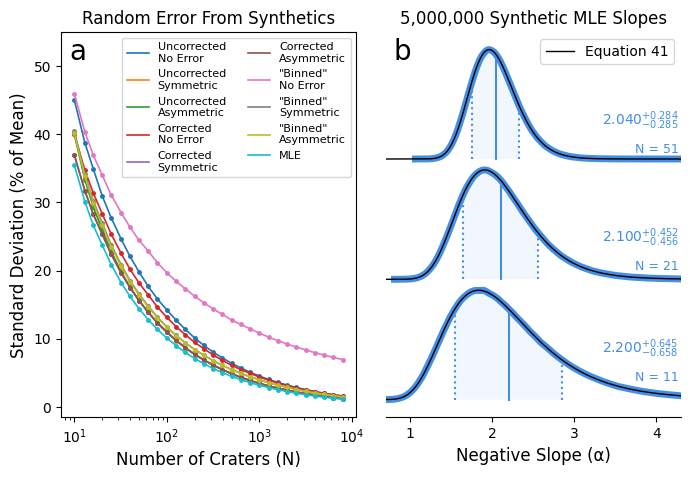

In [13]:
std_matrix = np.array([
    -100 * np.array(std_dict[key]) / np.array(mean_dict[key])
    for key in key_list
])

fig = plt.figure(figsize=(8, 5))

ax = fig.add_subplot(121)
label_dict = {
    'unbinned' : 'Uncorrected\nNo Error',
    'unbinned_u' : 'Uncorrected\nSymmetric',
    'unbinned_u_p' : 'Uncorrected\nAsymmetric',
    'unbinned_cor' : 'Corrected\nNo Error',
    'unbinned_cor_u' : 'Corrected\nSymmetric',
    'unbinned_cor_u_p' : 'Corrected\nAsymmetric',
    'left' : '\"Binned\"\nNo Error',
    'left_u' : '\"Binned\"\nSymmetric',
    'left_u_p' : '\"Binned\"\nAsymmetric',
    'mle' : 'MLE'
}
for i in range(10):
    plt.plot(
        N_array, std_matrix[i], 
        '.' , lw=0.5, ms=5, c=plt.get_cmap('tab10')(i)
    )
    plt.plot(
        N_array, std_matrix[i], 
        '-' , lw=1.2, label=label_dict[key_list[i]], ms=1,
        c=plt.get_cmap('tab10')(i)
    )
plt.xscale('log')
plt.legend(ncols=2, fontsize=8)
plt.xlabel('Number of Craters (N)', size=12)
plt.ylabel('Standard Deviation (% of Mean)', size=12)
plt.ylim([-1.5, 55])
plt.text(
    0.085, 0.985, 'a', 
    transform=plt.gca().transAxes, 
    ha='right', va='top', size=20
)
plt.title('Random Error From Synthetics')

ax = fig.add_subplot(122)
xlim = [0.7, 4.3]
X = np.linspace(xlim[0], xlim[1], 10000)
for i in range(len(mle_rvs)):
    mle_rvs[i].plot(
        upshift=1.1 * i, xlim=xlim, label=True,
        rounding_n=3, pdf_label='N = ' + str(mle_Ns[i]),
        lw=5, color=cs[0]
    )
    mle_P = pareto_mle_dist(X, 2, mle_Ns[i])
    mle_P = mle_P / mle_P.max()
    if i == 0:
        plt.plot(
            X, mle_P + 1.1 * i, 'k', lw=1.0,
            label='Equation 41'
        )
    else:
        plt.plot(
            X, mle_P + 1.1 * i, 'k', lw=1.0
        )
plt.xlabel('Negative Slope (α)', size=12)
erase_box(ax)
plt.text(
    0.085, 0.985, 'b', 
    transform=plt.gca().transAxes, 
    ha='right', va='top', size=20
)
plt.title('5,000,000 Synthetic MLE Slopes')
plt.legend()

fig.subplots_adjust(wspace=0.1)

pfig = plt.gcf()
pfig.savefig('figs/N_search_random_error.pdf', bbox_inches='tight')

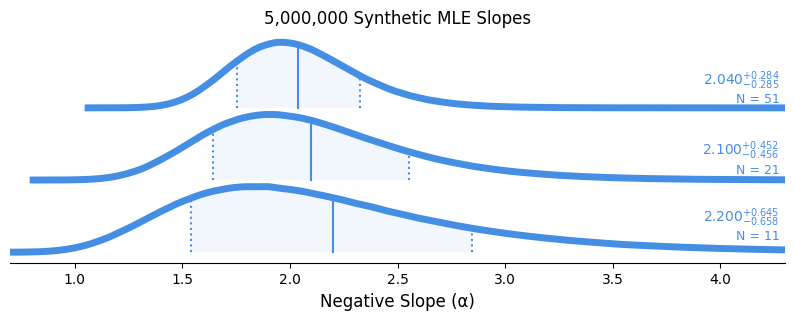

In [14]:
fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(111)
xlim = [0.7, 4.3]
X = np.linspace(xlim[0], xlim[1], 10000)
for i in range(len(mle_rvs)):
    mle_rvs[i].plot(
        upshift=1.1 * i, xlim=xlim, label=True,
        rounding_n=3, pdf_label='N = ' + str(mle_Ns[i]),
        lw=5, color=cs[0]
    )
plt.xlabel('Negative Slope (α)', size=12)
erase_box(ax)
plt.title('5,000,000 Synthetic MLE Slopes')

pfig = plt.gcf()
pfig.savefig('figs/N_search_mle_examples.pdf', bbox_inches='tight')

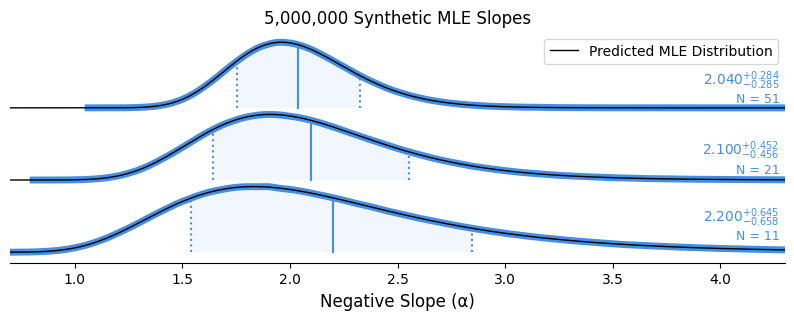

In [15]:
fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(111)
xlim = [0.7, 4.3]
X = np.linspace(xlim[0], xlim[1], 10000)
for i in range(len(mle_rvs)):
    mle_rvs[i].plot(
        upshift=1.1 * i, xlim=xlim, label=True,
        rounding_n=3, pdf_label='N = ' + str(mle_Ns[i]),
        lw=5, color=cs[0]
    )
    mle_P = pareto_mle_dist(X, 2, mle_Ns[i])
    mle_P = mle_P / mle_P.max()
    if i == 0:
        plt.plot(
            X, mle_P + 1.1 * i, 'k', lw=1.0,
            label='Predicted MLE Distribution'
        )
    else:
        plt.plot(
            X, mle_P + 1.1 * i, 'k', lw=1.0
        )
plt.xlabel('Negative Slope (α)', size=12)
erase_box(ax)

plt.title('5,000,000 Synthetic MLE Slopes')
plt.legend()

pfig = plt.gcf()
pfig.savefig('figs/N_search_mle_examples_with_predictions.pdf', bbox_inches='tight')